In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)
import missingno as msno
import math

# 데이터 불러오기
- train data, test data를 한 번에 처리하기 위해 하나의 dataframe으로 합침
- train, test 데이터 구분하기 위해 isTest feature 추가 (train: 0, test: 1)
- 평화님 데이터에서 가져올 column 선택

In [2]:
%%time
# dtype = {
#     'userID': 'int16',
#     'answerCode': 'int8',
#     'KnowledgeTag': 'int16',
# }   

# DATA_PATH = '/opt/ml/input/data/train_dataset/train_data.csv'
TRAIN_DATA_PATH = '/opt/ml/input/data/train_dataset/tuning_train_data.csv'
TEST_DATA_PATH = '/opt/ml/input/data/train_dataset/tuning_test_data.csv'
df_train = pd.read_csv(TRAIN_DATA_PATH, parse_dates=['Timestamp'])
df_test = pd.read_csv(TEST_DATA_PATH, parse_dates=['Timestamp'])

CPU times: user 11.7 s, sys: 1.6 s, total: 13.3 s
Wall time: 14.9 s


In [3]:
# train, test 구분 
df_train['isTest'] = [0 for _ in range(len(df_train))]
df_test['isTest'] = [1 for _ in range(len(df_test))]
print(len(df_train), len(df_test))

2266586 260114


In [4]:
# train, test 합친 후 정렬
df = pd.concat([df_train,df_test])
df = df.sort_values(by=['isTest', 'userID', 'Timestamp']).reset_index(drop=True)

In [5]:
df['Time'] = df['Timestamp'].transform(lambda x: int(x.strftime('%s')))

In [6]:
# 가져올 column 선택
df = df[['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 
         'Category', 'Number', 'Time', 'solTime', 'item', 'item_order', 'test_size', 'retest', 'user_test_ans_cnt', 'isTest']]

In [7]:
df.dtypes

userID                        int64
assessmentItemID             object
testId                       object
answerCode                    int64
Timestamp            datetime64[ns]
KnowledgeTag                  int64
Category                      int64
Number                       object
Time                          int64
solTime                       int64
item                          int64
item_order                    int64
test_size                     int64
retest                        int64
user_test_ans_cnt             int64
isTest                        int64
dtype: object

In [8]:
df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,Category,Number,Time,solTime,item,item_order,test_size,retest,user_test_ans_cnt,isTest
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,6,A001001,1585009031,3,0,0,6,0,0,0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,6,A001002,1585009034,8,1,1,6,0,1,0
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,6,A001003,1585009042,7,2,2,6,0,2,0
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,6,A001004,1585009049,7,3,3,6,0,3,0
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,6,A001005,1585009056,11,4,4,6,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2526695,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832,4,A130001,1602716843,18,0,0,5,0,0,1
2526696,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832,4,A130002,1602716861,21,1,1,5,0,1,1
2526697,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244,4,A130003,1602716882,89,2,2,5,0,2,1
2526698,7439,A040130004,A040000130,1,2020-10-14 23:09:31,8244,4,A130004,1602716971,32,3,3,5,0,3,1


# Train & Test 데이터 확인
- 사용자: train 6698명, test 744명, 겹치는 사용자 없음
- 문제: train 9454개, test 9454개, 모두 겹침
- 예측해야 하는 문제들: 444개

## 사용자

In [9]:
df.groupby(['userID', 'isTest']).agg({'answerCode': 'mean'})

,,answerCode
userID,isTest,
0,0,0.630872
1,0,0.853162
2,0,0.612319
3,1,0.691120
4,1,0.691505
...,...,...
7437,0,0.375000
7438,0,0.750000
7439,1,0.625000


In [10]:
# train 데이터에 포함된 user들
user_train_groupby = df[df['isTest']==0].groupby('userID').agg({'answerCode': 'mean'})
user_train_groupby.index

Int64Index([   0,    1,    2,    5,    6,    7,    8,    9,   10,   11,
            ...
            7431, 7432, 7433, 7434, 7435, 7436, 7437, 7438, 7440, 7441],
           dtype='int64', name='userID', length=6698)

In [11]:
# test 데이터에 포함된 user들
user_test_groupby = df[df['isTest']==1].groupby('userID').agg({'answerCode': 'mean'})
user_test_groupby.index

Int64Index([   3,    4,   13,   17,   26,   29,   45,   53,   58,   64,
            ...
            7368, 7369, 7373, 7382, 7392, 7395, 7404, 7416, 7417, 7439],
           dtype='int64', name='userID', length=744)

In [12]:
# 겹치는 user 수 확인
s1 = set(user_train_groupby.index)
s2 = set(user_test_groupby.index)
print(len(s1), len(s2), len(s1 & s2))

6698 744 0


## 문제

In [13]:
df.groupby(['assessmentItemID', 'isTest']).agg({'answerCode': 'mean'})

answerCode
assessmentItemID isTest            
A010001001       0         0.930599
                 1         0.848485
A010001002       0         0.958991
                 1         0.969697
A010001003       0         0.905363
...                             ...
A090074004       1         0.600000
A090074005       0         0.400000
                 1         0.400000
A090074006       0         0.466667
                 1        -0.600000

[18908 rows x 1 columns]

In [14]:
# train 데이터에 포함된 문제들
prob_train_groupby = df[df['isTest']==0].groupby('assessmentItemID').agg({'answerCode': 'mean'})
prob_train_groupby.index

Index(['A010001001', 'A010001002', 'A010001003', 'A010001004', 'A010001005',
       'A010002001', 'A010002002', 'A010002003', 'A010002004', 'A010002005',
       ...
       'A090073003', 'A090073004', 'A090073005', 'A090073006', 'A090074001',
       'A090074002', 'A090074003', 'A090074004', 'A090074005', 'A090074006'],
      dtype='object', name='assessmentItemID', length=9454)

In [15]:
# test 데이터에 포함된 문제들
prob_test_groupby = df[df['isTest']==1].groupby('assessmentItemID').agg({'answerCode': 'mean'})
prob_test_groupby.index

Index(['A010001001', 'A010001002', 'A010001003', 'A010001004', 'A010001005',
       'A010002001', 'A010002002', 'A010002003', 'A010002004', 'A010002005',
       ...
       'A090073003', 'A090073004', 'A090073005', 'A090073006', 'A090074001',
       'A090074002', 'A090074003', 'A090074004', 'A090074005', 'A090074006'],
      dtype='object', name='assessmentItemID', length=9454)

In [16]:
# 겹치는 문제 수 확인
s1 = set(prob_train_groupby.index)
s2 = set(prob_test_groupby.index)
print(len(s1), len(s2), len(s1 & s2))

9454 9454 9454


In [17]:
# 예측해야 하는 문제들
pred_prob_list = df[df['answerCode']==-1].groupby('assessmentItemID').agg({'answerCode': 'sum'}).index.tolist()
len(pred_prob_list)

444

# Timestamp 관련 feature
- 각 sequence의 마지막 문제는 정확한 풀이 시간을 알 수 없으므로 해당 사용자의 solTime 중앙값으로 대체
- clipped_solTime: solTime이 20분을 넘어가는 16478개의 데이터를 outlier로 간주하고 20분으로 자름
- clipped_solTime_cate: clipped_solTime 10초 단위로 구간 나눠서 카테고리화
- prob_mean_time: 문항별 평균 풀이 시간
- user_time_sum, user_time_mean: 사용자별 누적 소요 시간, 평균 누적 소요 시간
- moving_average_time: 최근 3문제 평균 풀이 시간
- user_test_time_sum: 사용자가 해당 시험지의 문제를 푼 누적 시간
- hour, weekday: 시간대, 요일

In [18]:
df1 = df.copy()

## solTime 마지막 값을 해당 사용자의 중앙값으로 대체

<AxesSubplot:>

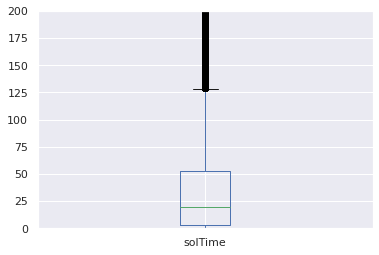

In [19]:
df1['solTime'].plot.box(ylim=[0,200])

In [20]:
solTime_median_groupby = df1.groupby('userID').agg({'solTime':'median'})
# solTime_median_groupby = df1.groupby('assessmentItemID').agg({'solTime':'median'})
solTime_median_groupby.head(30)

,solTime
userID,
0,14.0
1,50.0
2,17.0
3,24.0
4,35.0
5,35.0
6,9.0
7,19.0
8,28.0


In [21]:
index = (df1['answerCode']==-1).tolist()
index2 = df1.loc[index].index
index2

Int64Index([2267621, 2268292, 2269609, 2270869, 2271256, 2272110, 2273194,
            2273887, 2274698, 2275968,
            ...
            2526546, 2526563, 2526578, 2526596, 2526614, 2526638, 2526653,
            2526668, 2526683, 2526699],
           dtype='int64', length=744)

In [22]:
df1.loc[index]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,Category,Number,Time,solTime,item,item_order,test_size,retest,user_test_ans_cnt,isTest
2267621,3,A050133008,A050000133,-1,2020-10-26 13:13:57,5289,5,A133008,1603718037,0,7,7,8,0,7,1
2268292,4,A070146008,A070000146,-1,2020-12-27 02:47:54,9080,7,A146008,1609037274,0,7,7,8,0,7,1
2269609,13,A070111008,A070000111,-1,2020-12-27 04:35:09,9660,7,A111008,1609043709,0,7,7,8,0,7,1
2270869,17,A090064006,A090000064,-1,2020-10-30 05:48:37,2611,9,A064006,1604036917,0,5,5,6,0,5,1
2271256,26,A060135007,A060000135,-1,2020-10-23 11:44:18,1422,6,A135007,1603453458,0,6,6,7,0,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2526638,7395,A040122005,A040000122,-1,2020-09-08 02:05:20,10615,4,A122005,1599530720,0,4,4,5,0,4,1
2526653,7404,A030111005,A030000111,-1,2020-10-13 09:49:18,7636,3,A111005,1602582558,0,4,4,5,0,4,1
2526668,7416,A050193004,A050000193,-1,2020-10-04 02:44:41,10402,5,A193004,1601779481,0,3,3,4,0,3,1
2526683,7417,A050193004,A050000193,-1,2020-09-06 13:09:15,10402,5,A193004,1599397755,0,3,3,4,0,3,1


In [23]:
df1.loc[index, 'solTime']

2267621    0
2268292    0
2269609    0
2270869    0
2271256    0
          ..
2526638    0
2526653    0
2526668    0
2526683    0
2526699    0
Name: solTime, Length: 744, dtype: int64

In [24]:
# df1.loc[index, 'assessmentItemID']
df1.loc[index, 'userID']

2267621       3
2268292       4
2269609      13
2270869      17
2271256      26
           ... 
2526638    7395
2526653    7404
2526668    7416
2526683    7417
2526699    7439
Name: userID, Length: 744, dtype: int64

In [25]:
# median = solTime_median_groupby.loc[df1.loc[index, 'assessmentItemID']].reset_index()['solTime']
median = solTime_median_groupby.loc[df1.loc[index, 'userID']].reset_index()['solTime']
median.index = index2
median

2267621    24.0
2268292    35.0
2269609    20.0
2270869    35.0
2271256    20.0
           ... 
2526638     2.5
2526653    15.0
2526668    14.0
2526683    31.0
2526699    19.5
Name: solTime, Length: 744, dtype: float64

In [26]:
df1.loc[index, 'solTime'] = median
df1.loc[index]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,Category,Number,Time,solTime,item,item_order,test_size,retest,user_test_ans_cnt,isTest
2267621,3,A050133008,A050000133,-1,2020-10-26 13:13:57,5289,5,A133008,1603718037,24.0,7,7,8,0,7,1
2268292,4,A070146008,A070000146,-1,2020-12-27 02:47:54,9080,7,A146008,1609037274,35.0,7,7,8,0,7,1
2269609,13,A070111008,A070000111,-1,2020-12-27 04:35:09,9660,7,A111008,1609043709,20.0,7,7,8,0,7,1
2270869,17,A090064006,A090000064,-1,2020-10-30 05:48:37,2611,9,A064006,1604036917,35.0,5,5,6,0,5,1
2271256,26,A060135007,A060000135,-1,2020-10-23 11:44:18,1422,6,A135007,1603453458,20.0,6,6,7,0,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2526638,7395,A040122005,A040000122,-1,2020-09-08 02:05:20,10615,4,A122005,1599530720,2.5,4,4,5,0,4,1
2526653,7404,A030111005,A030000111,-1,2020-10-13 09:49:18,7636,3,A111005,1602582558,15.0,4,4,5,0,4,1
2526668,7416,A050193004,A050000193,-1,2020-10-04 02:44:41,10402,5,A193004,1601779481,14.0,3,3,4,0,3,1
2526683,7417,A050193004,A050000193,-1,2020-09-06 13:09:15,10402,5,A193004,1599397755,31.0,3,3,4,0,3,1


## solTime 20분 넘으면 자르기

In [27]:
df1_1 = df1.copy()
df1_1['solTime_cut'] = np.digitize(df1['solTime'], bins=[1200])
solTime_groupby = df1_1.groupby('solTime_cut').agg({'userID': 'count'})
solTime_groupby.index.name = 'solTime_cut'
solTime_groupby.reset_index(inplace=True)
solTime_groupby

,solTime_cut,userID
0,0,2510222
1,1,16478


<AxesSubplot:ylabel='userID'>

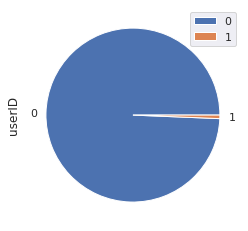

In [28]:
solTime_groupby.plot.pie(x='solTime_cate', y='userID')

In [29]:
len(df1[df1['solTime'] <= 1200])

2510239

In [30]:
len(df1[df1['solTime'] > 1200])

16461

In [31]:
df1['clipped_solTime'] = df1['solTime'].transform(lambda x: x if x <= 1200 else 1200)
df1['clipped_solTime'].describe()

count    2.526700e+06
mean     5.841117e+01
std      1.378429e+02
min      0.000000e+00
25%      3.000000e+00
50%      2.000000e+01
75%      5.300000e+01
max      1.200000e+03
Name: clipped_solTime, dtype: float64

In [32]:
clipped_solTime_groupby = df1.groupby('clipped_solTime').agg({'answerCode': 'mean'})
clipped_solTime_groupby.index.name = 'clipped_solTime'
clipped_solTime_groupby.reset_index(inplace=True)
clipped_solTime_groupby

,clipped_solTime,answerCode
0,0.0,0.558025
1,1.0,0.258033
2,2.0,0.239921
3,2.5,-1.000000
4,3.0,0.258322
...,...,...
1239,1196.0,0.666667
1240,1197.0,0.800000
1241,1198.0,0.642857
1242,1199.0,0.789474


In [33]:
clipped_solTime_groupby.head(20)

,clipped_solTime,answerCode
0,0.0,0.558025
1,1.0,0.258033
2,2.0,0.239921
3,2.5,-1.000000
4,3.0,0.258322
5,3.5,-1.000000
6,4.0,0.288264
7,4.5,-1.000000
8,5.0,0.369349
9,5.5,-1.000000


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='clipped_solTime', ylabel='answerCode'>

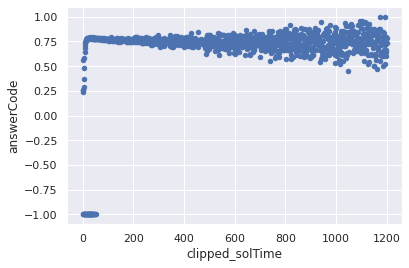

In [34]:
clipped_solTime_groupby.plot.scatter(x='clipped_solTime', y='answerCode')

In [35]:
# 카테고리화
df1['clipped_solTime_cate'] = df1['clipped_solTime'].transform(lambda x: math.floor(x/10))
df1[['clipped_solTime','clipped_solTime_cate']]

,clipped_solTime,clipped_solTime_cate
0,3.0,0
1,8.0,0
2,7.0,0
3,7.0,0
4,11.0,1
...,...,...
2526695,18.0,1
2526696,21.0,2
2526697,89.0,8
2526698,32.0,3


In [36]:
clipped_solTime_cate_groupby = df1.groupby('clipped_solTime_cate').agg({'answerCode': 'mean'})
clipped_solTime_cate_groupby.index.name = 'clipped_solTime_cate'
clipped_solTime_cate_groupby.reset_index(inplace=True)
clipped_solTime_cate_groupby

,clipped_solTime_cate,answerCode
0,0,0.449941
1,1,0.761955
2,2,0.783919
3,3,0.783870
4,4,0.781299
...,...,...
116,116,0.783626
117,117,0.721088
118,118,0.711268
119,119,0.697842


In [37]:
df1['clipped_solTime'].describe()

count    2.526700e+06
mean     5.841117e+01
std      1.378429e+02
min      0.000000e+00
25%      3.000000e+00
50%      2.000000e+01
75%      5.300000e+01
max      1.200000e+03
Name: clipped_solTime, dtype: float64

In [38]:
# 예측해야 하는 행 제외한 데이터
df1_1 = df1[df1['answerCode'] != -1]
len(df1_1)

2525956

## 문항별 평균 소요 시간

In [39]:
prob_groupby = df1_1.groupby(['assessmentItemID'])['clipped_solTime'].agg(['mean'])
prob_groupby.columns = ['prob_mean_time']
prob_groupby

,prob_mean_time
assessmentItemID,
A010001001,27.848571
A010001002,20.654286
A010001003,50.254286
A010001004,55.497143
A010001005,0.174286
...,...
A090074002,44.400000
A090074003,21.000000
A090074004,38.780000


In [40]:
df1 = pd.merge(df1, prob_groupby, on=['assessmentItemID'], how="left")
df1['prob_mean_time']

0          13.660000
1          26.112000
2          19.180000
3          18.076000
4          35.720000
             ...    
2526695    64.400000
2526696    43.046667
2526697    76.566667
2526698    69.203333
2526699     4.374582
Name: prob_mean_time, Length: 2526700, dtype: float64

In [41]:
df1[df1['assessmentItemID']=='A010001001']

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,Category,Number,Time,solTime,item,item_order,test_size,retest,user_test_ans_cnt,isTest,clipped_solTime,clipped_solTime_cate,prob_mean_time
4544,8,A010001001,A010000001,1,2020-03-01 08:36:27,5844,1,A001001,1583051787,44.0,0,0,5,0,0,0,44.0,4,27.848571
8111,14,A010001001,A010000001,1,2020-07-10 08:58:07,5844,1,A001001,1594371487,11.0,0,0,5,0,0,0,11.0,1,27.848571
9746,16,A010001001,A010000001,1,2020-03-12 21:46:25,5844,1,A001001,1584049585,48.0,0,0,5,0,0,0,48.0,4,27.848571
11222,18,A010001001,A010000001,1,2020-07-14 12:37:21,5844,1,A001001,1594730241,17.0,0,0,5,0,0,0,17.0,1,27.848571
33368,46,A010001001,A010000001,0,2020-03-18 02:01:40,5844,1,A001001,1584496900,10.0,0,0,5,0,0,0,10.0,1,27.848571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2492684,3876,A010001001,A010000001,1,2020-03-26 13:24:47,5844,1,A001001,1585229087,38.0,0,0,5,0,0,1,38.0,3,27.848571
2494878,3986,A010001001,A010000001,1,2020-03-27 12:46:12,5844,1,A001001,1585313172,15.0,0,0,5,0,0,1,15.0,1,27.848571
2509052,4819,A010001001,A010000001,1,2020-03-30 04:59:07,5844,1,A001001,1585544347,15.0,0,0,5,0,0,1,15.0,1,27.848571
2511459,5066,A010001001,A010000001,1,2020-04-01 09:02:56,5844,1,A001001,1585731776,18.0,0,0,5,0,0,1,18.0,1,27.848571


## 사용자별 소요시간

In [42]:
df_user = df1.groupby('userID')['answerCode']
df_solTime = df1.groupby('userID')['clipped_solTime']

# 누적 소요시간
df1['shift'] = df_solTime.shift().fillna(0)
df1['user_time_sum'] = df1.groupby('userID')['shift'].cumsum()
df1 = df1.drop(columns='shift')


# 누적 평균 소요시간
df1['user_time_mean'] = (df1['user_time_sum'] / df_user.cumcount()).fillna(0)
df1[['user_time_sum', 'user_time_mean']]

,user_time_sum,user_time_mean
0,0.0,0.000000
1,3.0,3.000000
2,11.0,5.500000
3,18.0,6.000000
4,25.0,6.250000
...,...,...
2526695,371.0,33.727273
2526696,389.0,32.416667
2526697,410.0,31.538462
2526698,499.0,35.642857


## 사용자가 해당 시험지의 문제를 푼 누적 시간 

In [43]:
df1['user_test_time_sum'] = df1.groupby(['userID', 'testId'])['clipped_solTime'].cumsum()

## 최근 3문제 평균 풀이 시간

In [44]:
df1['moving_average_time'] = df1.groupby(['userID'])['clipped_solTime'].rolling(3).mean().fillna(0).values
df1[['userID', 'clipped_solTime', 'moving_average_time']]

,userID,clipped_solTime,moving_average_time
0,0,3.0,0.000000
1,0,8.0,0.000000
2,0,7.0,6.000000
3,0,7.0,7.333333
4,0,11.0,8.333333
...,...,...,...
2526695,7439,18.0,19.333333
2526696,7439,21.0,11.666667
2526697,7439,89.0,19.000000
2526698,7439,32.0,43.333333


In [45]:
moving_average_time_groupby = df1.groupby('moving_average_time').agg({'answerCode': 'mean'})
moving_average_time_groupby.index.name = 'moving_average_time'
moving_average_time_groupby.reset_index(inplace=True)
moving_average_time_groupby

,moving_average_time,answerCode
0,0.000000,0.640629
1,0.333333,0.643881
2,0.666667,0.650326
3,1.000000,0.645350
4,1.333333,0.645867
...,...,...
3227,1196.000000,1.000000
3228,1196.333333,1.000000
3229,1197.333333,1.000000
3230,1198.666667,1.000000


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='moving_average_time', ylabel='answerCode'>

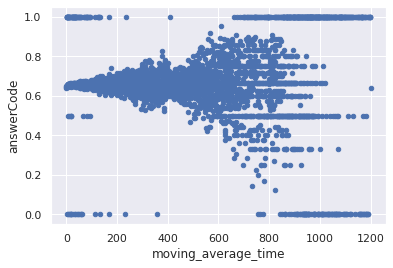

In [46]:
moving_average_time_groupby.plot.scatter(x='moving_average_time', y='answerCode')

## 시간대 & 요일

In [47]:
df1['hour'] = df1['Timestamp'].transform(lambda x: pd.to_datetime(x).dt.hour)
df1['weekday'] = df1['Timestamp'].transform(lambda x: pd.to_datetime(x).dt.weekday)

In [48]:
hour_groupby = df1.groupby('hour').agg({'answerCode': 'mean'})
hour_groupby.index.name = 'hour'
hour_groupby.reset_index(inplace=True)
hour_groupby

,hour,answerCode
0,0,0.650462
1,1,0.644876
2,2,0.642090
3,3,0.633329
4,4,0.633352
5,5,0.624684
6,6,0.628330
7,7,0.641452
8,8,0.669495
9,9,0.682831


<AxesSubplot:xlabel='hour'>

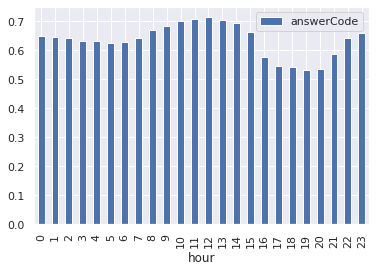

In [49]:
hour_groupby.plot.bar(x='hour', y='answerCode')

In [50]:
weekday_groupby = df1.groupby('weekday').agg({'answerCode': 'mean'})
weekday_groupby.index.name = 'weekday'
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
weekday_groupby['weekday_name'] = days
weekday_groupby.reset_index(inplace=True)
weekday_groupby.head(24)

,weekday,answerCode,weekday_name
0,0,0.675781,Mon
1,1,0.667045,Tue
2,2,0.641120,Wed
3,3,0.657922,Thu
4,4,0.643650,Fri
5,5,0.603369,Sat
6,6,0.674146,Sun


<AxesSubplot:xlabel='weekday_name'>

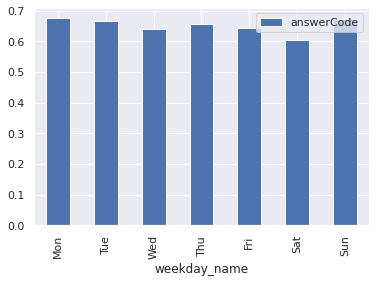

In [51]:
weekday_groupby.plot.bar(x='weekday_name', y='answerCode')

In [52]:
df1

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,Category,Number,Time,solTime,...,isTest,clipped_solTime,clipped_solTime_cate,prob_mean_time,user_time_sum,user_time_mean,user_test_time_sum,moving_average_time,hour,weekday
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,6,A001001,1585009031,3.0,...,0,3.0,0,13.660000,0.0,0.000000,3.0,0.000000,0,1
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,6,A001002,1585009034,8.0,...,0,8.0,0,26.112000,3.0,3.000000,11.0,0.000000,0,1
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,6,A001003,1585009042,7.0,...,0,7.0,0,19.180000,11.0,5.500000,18.0,6.000000,0,1
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,6,A001004,1585009049,7.0,...,0,7.0,0,18.076000,18.0,6.000000,25.0,7.333333,0,1
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,6,A001005,1585009056,11.0,...,0,11.0,1,35.720000,25.0,6.250000,36.0,8.333333,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2526695,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832,4,A130001,1602716843,18.0,...,1,18.0,1,64.400000,371.0,33.727273,18.0,19.333333,23,2
2526696,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832,4,A130002,1602716861,21.0,...,1,21.0,2,43.046667,389.0,32.416667,39.0,11.666667,23,2
2526697,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244,4,A130003,1602716882,89.0,...,1,89.0,8,76.566667,410.0,31.538462,128.0,19.000000,23,2
2526698,7439,A040130004,A040000130,1,2020-10-14 23:09:31,8244,4,A130004,1602716971,32.0,...,1,32.0,3,69.203333,499.0,35.642857,160.0,43.333333,23,2


# 총 개수 & 맞춘 개수 & 정답률
- 문항, 시험지, 태그별 feature들은 난이도를 파악하기 위한 것이므로 전체 데이터로 계산
- 사용자와 관련된 feature들은 시간에 따른 변화를 반영하기 위해 누적합으로 계산
- Feature 이름 설명
    - 누적
        - past_X_count: 과거에 푼 총 누적 개수
        - past_X_correct: 과거에 맞춘 누적 개수
        - average_X_correct: 누적 정답률 (past_X_correct / past_X_count)
    - 전체
        - X_mean: 평균 정답률
        - X_sum: 총 개수
        
- 문항별 - 문항의 난이도 파악
    - 누적: past_prob_count, past_prob_correct, average_prob_correct
    - 전체: prob_mean, prob_sum
    - prob_mean_cate: prob_mean 카테고리화 (난이도 레벨)
- 시험지별 - 시험지의 난이도 파악
    - 누적: past_test_count, past_test_correct, average_test_correct
    - 전체: test_mean, test_sum
- 태그별 - 태그의 난이도 파악
    - 누적: past_tag_count, past_tag_correct, average_tag_correct
    - 전체: tag_mean, tag_sum
- 사용자별 - 사용자의 실력 파악
    - 누적: past_user_count, past_user_correct, average_user_correct
    - average_user_correct_cate: average_user_correct 카테고리화 (사용자의 레벨)
    - moving_average_user_correct_10, moving_average_user_correct_5: 사용자의 집중력, 추세를 파악하기 위해 최근 10문제 / 5문제의 정답률 계산
- 사용자 + 문항별 - 사용자가 같은 문제를 반복해서 풀었는지 파악
    - 누적: past_user_prob_count, past_user_prob_correct, past_user_prob_correct
- 사용자 + 시험지별 - 사용자가 해당 시험을 몇 번째 풀었는지 파악
    - 누적: past_user_test_count, past_user_test_correct, average_user_test_correct
- 사용자 + 태그별 - 사용자가 해당 태그에 얼마나 강한지 파악
    - 누적: past_user_tag_count, past_user_tag_correct, average_user_tag_correct

In [53]:
# 비율 계산하는 함수
def percentile(s):
    return np.sum(s) / len(s)

In [54]:
df2 = df1.copy()

In [55]:
# 시간 순서대로 정렬
df2 = df2.sort_values(by=['Timestamp', 'isTest']).reset_index(drop=True)

In [56]:
df2

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,Category,Number,Time,solTime,...,isTest,clipped_solTime,clipped_solTime_cate,prob_mean_time,user_time_sum,user_time_mean,user_test_time_sum,moving_average_time,hour,weekday
0,784,A060014001,A060000014,1,2019-12-31 15:08:01,7229,6,A014001,1577804881,20.0,...,0,20.0,2,55.172,0.0,0.000000,20.0,16.000000,15,1
1,784,A060014002,A060000014,1,2019-12-31 15:08:21,7229,6,A014002,1577804901,34.0,...,0,34.0,3,68.144,20.0,20.000000,54.0,14.333333,15,1
2,784,A060014003,A060000014,1,2019-12-31 15:08:55,7229,6,A014003,1577804935,18.0,...,0,18.0,1,76.116,54.0,27.000000,72.0,19.000000,15,1
3,784,A060014004,A060000014,1,2019-12-31 15:09:13,7229,6,A014004,1577804953,16.0,...,0,16.0,1,54.176,72.0,24.000000,88.0,26.666667,15,1
4,784,A060014005,A060000014,0,2019-12-31 15:09:29,7229,6,A014005,1577804969,0.0,...,0,0.0,0,0.812,88.0,22.000000,88.0,37.000000,15,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2526695,588,A070152004,A070000152,0,2020-12-29 16:46:08,7866,7,A152004,1609260368,5.0,...,0,5.0,0,141.960,68109.0,109.149038,54.0,16.000000,16,1
2526696,588,A070152005,A070000152,1,2020-12-29 16:46:13,3288,7,A152005,1609260373,2.0,...,0,2.0,0,104.460,68114.0,108.982400,56.0,18.333333,16,1
2526697,588,A070152006,A070000152,0,2020-12-29 16:46:15,9078,7,A152006,1609260375,3.0,...,0,3.0,0,49.620,68116.0,108.811502,59.0,6.333333,16,1
2526698,588,A070152007,A070000152,0,2020-12-29 16:46:18,9080,7,A152007,1609260378,3.0,...,0,3.0,0,68.360,68119.0,108.642743,62.0,13.000000,16,1


In [57]:
# 예측해야 하는 행 제외한 데이터
df2_1 = df2[df2['answerCode'] != -1]
len(df2_1)

2525956

## 문항별(누적)

In [58]:
df_prob = df2.groupby('assessmentItemID')['answerCode']

# 특정 문항 과거에 푼 횟수
df2['past_prob_count'] = df_prob.cumcount()

# 특정 문항 과거에 맞춘 횟수
df2['shift'] = df_prob.shift().fillna(0)
df2['past_prob_correct'] = df2.groupby('assessmentItemID')['shift'].cumsum()
df2 = df2.drop(columns='shift')

# 특정 문항 과거 평균 정답률
df2['average_prob_correct'] = (df2['past_prob_correct'] / df2['past_prob_count']).fillna(0)

In [59]:
prob_groupby = df2.groupby('past_prob_count').agg({
    'answerCode': percentile
})
prob_groupby.index.name = 'past_prob_count'
prob_groupby.reset_index(inplace=True)
prob_groupby.describe()

,past_prob_count,answerCode
count,500.000000,500.000000
mean,249.500000,0.583850
std,144.481833,0.118000
min,0.000000,0.125000
25%,124.750000,0.499259
50%,249.500000,0.641802
75%,374.250000,0.662472
max,499.000000,0.757351


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='past_prob_count', ylabel='answerCode'>

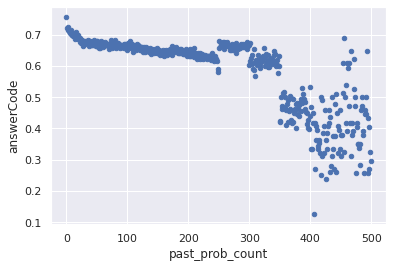

In [60]:
prob_groupby.plot.scatter(x='past_prob_count', y='answerCode')

## 문항별(전체)

In [61]:
# 문항별 전체 정답률
prob_groupby = df1_1.groupby(['assessmentItemID'])['answerCode'].agg(['mean', 'sum'])
prob_groupby.columns = ['prob_mean', 'prob_sum']

In [62]:
df2 = pd.merge(df2, prob_groupby, on=['assessmentItemID'], how="left")

In [63]:
# 카테고리화
df2['prob_mean_cate'] = df2['prob_mean'].transform(lambda x: math.floor(x*10))
df2[['prob_mean','prob_mean_cate']]

,prob_mean,prob_mean_cate
0,0.892,8
1,0.892,8
2,0.340,3
3,0.588,5
4,0.232,2
...,...,...
2526695,0.670,6
2526696,0.600,6
2526697,0.330,3
2526698,0.490,4


## 시험지별(누적)

In [64]:
df_test = df2.groupby('testId')['answerCode']

# 특정 시험지 과거에 푼 횟수
df2['past_test_count'] = df_test.cumcount()

# 특정 시험지 과거에 맞춘 횟수
df2['shift'] = df_test.shift().fillna(0)
df2['past_test_correct'] = df2.groupby('testId')['shift'].cumsum()
df2 = df2.drop(columns='shift')

# 특정 시험지 과거 평균 정답률
df2['average_test_correct'] = (df2['past_test_correct'] / df2['past_test_count']).fillna(0)

In [65]:
test_groupby = df2.groupby('past_test_count').agg({
    'answerCode': percentile
})
test_groupby.index.name = 'past_test_count'
test_groupby.reset_index(inplace=True)
test_groupby.describe()

,past_test_count,answerCode
count,4400.000000,4400.000000
mean,2199.500000,0.552078
std,1270.314922,0.196285
min,0.000000,-1.000000
25%,1099.750000,0.462753
50%,2199.500000,0.575702
75%,3299.250000,0.671242
max,4399.000000,1.000000


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='past_test_count', ylabel='answerCode'>

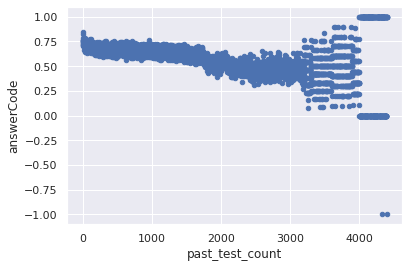

In [66]:
test_groupby.plot.scatter(x='past_test_count', y='answerCode')

## 시험지별(전체)

In [67]:
# 시험지별 전체 정답률
test_groupby = df1_1.groupby(['testId'])['answerCode'].agg(['mean', 'sum'])
test_groupby.columns = ["test_mean", 'test_sum']

In [68]:
df2 = pd.merge(df2, test_groupby, on=['testId'], how="left")

## 태그별(누적)

In [69]:
df_tag = df2.groupby('KnowledgeTag')['answerCode']

# 특정 태그 과거에 푼 횟수
df2['past_tag_count'] = df_tag.cumcount()

# 특정 태그 과거에 맞춘 횟수
df2['shift'] = df_tag.shift().fillna(0)
df2['past_tag_correct'] = df2.groupby('KnowledgeTag')['shift'].cumsum()
df2 = df2.drop(columns='shift')

# 특정 태그 과거 평균 정답률
df2['average_tag_correct'] = (df2['past_tag_correct'] / df2['past_tag_count']).fillna(0)

In [70]:
tag_groupby = df2.groupby('past_tag_count').agg({
    'answerCode': percentile
})
tag_groupby.index.name = 'past_tag_count'
tag_groupby.reset_index(inplace=True)
tag_groupby.describe()

,past_tag_count,answerCode
count,14350.000000,14350.000000
mean,7174.500000,0.697500
std,4142.632516,0.211853
min,0.000000,0.000000
25%,3587.250000,0.625000
50%,7174.500000,0.666667
75%,10761.750000,0.783235
max,14349.000000,1.000000


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='past_tag_count', ylabel='answerCode'>

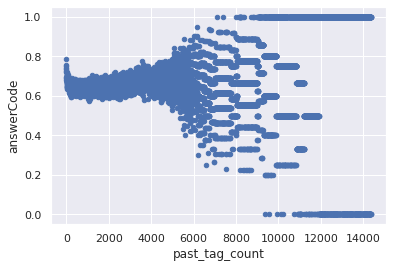

In [71]:
tag_groupby.plot.scatter(x='past_tag_count', y='answerCode')

## 태그별(전체)

In [72]:
# 태그별 전체 정답률
tag_groupby = df1_1.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum'])
tag_groupby.columns = ["tag_mean", 'tag_sum']

In [73]:
df2 = pd.merge(df2, tag_groupby, on=['KnowledgeTag'], how="left")

## 사용자별

In [74]:
df_user = df2.groupby('userID')['answerCode']

# 과거에 푼 문제 수
df2['past_user_count'] = df_user.cumcount()

# 과거에 맞춘 문제 수
df2['shift'] = df_user.shift().fillna(0)
df2['past_user_correct'] = df2.groupby('userID')['shift'].cumsum()
df2 = df2.drop(columns='shift')

# 과거 평균 정답률
df2['average_user_correct'] = (df2['past_user_correct'] / df2['past_user_count']).fillna(0)

In [75]:
user_groupby = df2.groupby('past_user_count').agg({
    'answerCode': percentile
})
user_groupby.index.name = 'past_user_count'
user_groupby.reset_index(inplace=True)
user_groupby.describe()

,past_user_count,answerCode
count,1860.000000,1860.000000
mean,929.500000,0.647544
std,537.080069,0.105707
min,0.000000,0.000000
25%,464.750000,0.642489
50%,929.500000,0.657800
75%,1394.250000,0.673501
max,1859.000000,1.000000


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='past_user_count', ylabel='answerCode'>

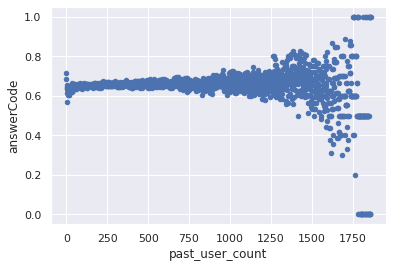

In [76]:
user_groupby.plot.scatter(x='past_user_count', y='answerCode')

In [77]:
# 카테고리화
df2['average_user_correct_cate'] = df2['average_user_correct'].transform(lambda x: math.floor(x*10))
df2[['average_user_correct','average_user_correct_cate']]

,average_user_correct,average_user_correct_cate
0,0.000000,0
1,1.000000,10
2,1.000000,10
3,1.000000,10
4,1.000000,10
...,...,...
2526695,0.538462,5
2526696,0.537600,5
2526697,0.538339,5
2526698,0.537480,5


In [78]:
# 이동평균(추세)
df2['shift'] = df_user.shift().fillna(0)
df2['moving_average_user_correct_10'] = df2['shift'].rolling(10).mean().fillna(0)
df2['moving_average_user_correct_5'] = df2['shift'].rolling(5).mean().fillna(0)
df2 = df2.drop(columns='shift')
df2[df2['userID']==0][['answerCode', 'moving_average_user_correct_5']].head(30)

,answerCode,moving_average_user_correct_5
267671,1,0.8
267672,1,0.8
267675,1,0.8
267678,1,1.0
267681,1,1.0
267685,1,1.0
289272,0,0.8
289274,1,0.6
289294,1,1.0
289300,1,0.4


In [79]:
moving_user_groupby = df2.groupby('moving_average_user_correct_5').agg({
    'answerCode': percentile
})
moving_user_groupby.index.name = 'moving_average_user_correct_5'
moving_user_groupby.reset_index(inplace=True)
moving_user_groupby.describe()

,moving_average_user_correct_5,answerCode
count,6.000000,6.000000
mean,0.500000,0.562889
std,0.374166,0.204854
min,0.000000,0.271158
25%,0.250000,0.424663
50%,0.500000,0.590400
75%,0.750000,0.716232
max,1.000000,0.797782


In [80]:
moving_user_groupby

,moving_average_user_correct_5,answerCode
0,0.0,0.271158
1,0.2,0.389832
2,0.4,0.529157
3,0.6,0.651644
4,0.8,0.737762
5,1.0,0.797782


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='moving_average_user_correct_5', ylabel='answerCode'>

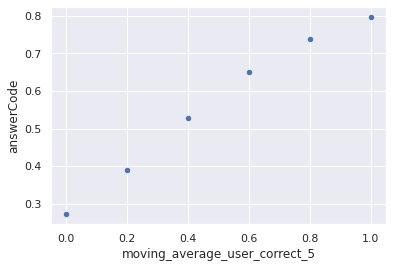

In [81]:
moving_user_groupby.plot.scatter(x='moving_average_user_correct_5', y='answerCode')

## 사용자 + 문항별

In [82]:
df_user_prob = df2.groupby(['userID','assessmentItemID'])['answerCode']

# 과거에 해당 문제를 푼 수
df2['past_user_prob_count'] = df_user_prob.cumcount()

# 과거에 해당 문제를 맞춘 횟수
df2['shift'] = df_user_prob.shift().fillna(0)
df2['past_user_prob_correct'] = df2.groupby(['userID', 'assessmentItemID'])['shift'].cumsum()
df2 = df2.drop(columns='shift')

# 과거 해당 문제 평균 정답률
df2['ㅊ'] = (df2['past_user_prob_correct'] / df2['past_user_prob_count']).fillna(0)

In [83]:
user_prob_groupby = df2.groupby('past_user_prob_count').agg({
    'userID': 'count',
    'answerCode': percentile
})
user_prob_groupby.index.name = 'past_user_prob_count'
user_prob_groupby.reset_index(inplace=True)
user_prob_groupby

,past_user_prob_count,userID,answerCode
0,0,2476706,0.654363
1,1,49100,0.647088
2,2,894,0.454139


<AxesSubplot:ylabel='userID'>

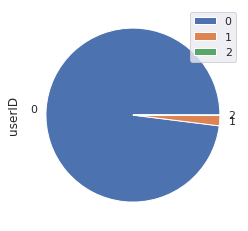

In [84]:
user_prob_groupby.plot.pie(x='past_user_prob_count', y='userID')

## 사용자 + 시험지별

In [85]:
df_user_test = df2.groupby(['userID','testId'])['answerCode']

# 과거에 해당 시험지를 푼 수
df2['past_user_test_count'] = df_user_test.cumcount()

# 과거에 해당 시험지를 맞춘 횟수
df2['shift'] = df_user_test.shift().fillna(0)
df2['past_user_test_correct'] = df2.groupby(['userID', 'testId'])['shift'].cumsum()
df2 = df2.drop(columns='shift')

# 과거 해당 시험지 평균 정답률
df2['average_user_test_correct'] = (df2['past_user_test_correct'] / df2['past_user_test_count']).fillna(0)

In [86]:
user_test_groupby = df2.groupby('past_user_test_count').agg({
    'userID': 'count',
    'answerCode': percentile
})
user_test_groupby.index.name = 'past_user_test_count'
user_test_groupby.reset_index(inplace=True)
user_test_groupby

,past_user_test_count,userID,answerCode
0,0,407189,0.750863
1,1,407189,0.721446
2,2,406901,0.690455
3,3,405125,0.662892
4,4,391445,0.598122
5,5,219828,0.557677
6,6,142792,0.518208
7,7,79233,0.468353
8,8,27039,0.528163
9,9,13399,0.580416


## 사용자 + 태그별

In [87]:
df_user_tag = df2.groupby(['userID','KnowledgeTag'])['answerCode']

# 과거에 해당 태그를 푼 수
df2['past_user_tag_count'] = df_user_tag.cumcount()

# 과거에 해당 태그를 맞춘 횟수
df2['shift'] = df_user_tag.shift().fillna(0)
df2['past_user_tag_correct'] = df2.groupby(['userID', 'KnowledgeTag'])['shift'].cumsum()
df2 = df2.drop(columns='shift')

# 과거 해당 태그 평균 정답률
df2['average_user_tag_correct'] = (df2['past_user_tag_correct'] / df2['past_user_tag_count']).fillna(0)

In [88]:
user_tag_groupby = df2.groupby('past_user_tag_count').agg({
    'userID': 'count',
    'answerCode': percentile
})
user_tag_groupby.index.name = 'past_user_tag_count'
user_tag_groupby.reset_index(inplace=True)
user_tag_groupby

,past_user_tag_count,userID,answerCode
0,0,492354,0.687444
1,1,422906,0.669106
2,2,367129,0.650831
3,3,315447,0.643243
4,4,269447,0.599376
...,...,...,...
103,103,1,1.000000
104,104,1,1.000000
105,105,1,0.000000
106,106,1,0.000000


# CSV 파일 저장

In [89]:
df2.dtypes

userID                                     int64
assessmentItemID                          object
testId                                    object
answerCode                                 int64
Timestamp                         datetime64[ns]
KnowledgeTag                               int64
Category                                   int64
Number                                    object
Time                                       int64
solTime                                  float64
item                                       int64
item_order                                 int64
test_size                                  int64
retest                                     int64
user_test_ans_cnt                          int64
isTest                                     int64
clipped_solTime                          float64
clipped_solTime_cate                       int64
prob_mean_time                           float64
user_time_sum                            float64
user_time_mean      

In [90]:
df2

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,Category,Number,Time,solTime,...,moving_average_user_correct_5,past_user_prob_count,past_user_prob_correct,ㅊ,past_user_test_count,past_user_test_correct,average_user_test_correct,past_user_tag_count,past_user_tag_correct,average_user_tag_correct
0,784,A060014001,A060000014,1,2019-12-31 15:08:01,7229,6,A014001,1577804881,20.0,...,0.0,0,0.0,0.0,0,0.0,0.000000,0,0.0,0.00
1,784,A060014002,A060000014,1,2019-12-31 15:08:21,7229,6,A014002,1577804901,34.0,...,0.0,0,0.0,0.0,1,1.0,1.000000,1,1.0,1.00
2,784,A060014003,A060000014,1,2019-12-31 15:08:55,7229,6,A014003,1577804935,18.0,...,0.0,0,0.0,0.0,2,2.0,1.000000,2,2.0,1.00
3,784,A060014004,A060000014,1,2019-12-31 15:09:13,7229,6,A014004,1577804953,16.0,...,0.0,0,0.0,0.0,3,3.0,1.000000,3,3.0,1.00
4,784,A060014005,A060000014,0,2019-12-31 15:09:29,7229,6,A014005,1577804969,0.0,...,0.8,0,0.0,0.0,4,4.0,1.000000,4,4.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2526695,588,A070152004,A070000152,0,2020-12-29 16:46:08,7866,7,A152004,1609260368,5.0,...,0.2,0,0.0,0.0,3,1.0,0.333333,0,0.0,0.00
2526696,588,A070152005,A070000152,1,2020-12-29 16:46:13,3288,7,A152005,1609260373,2.0,...,0.2,0,0.0,0.0,4,1.0,0.250000,1,0.0,0.00
2526697,588,A070152006,A070000152,0,2020-12-29 16:46:15,9078,7,A152006,1609260375,3.0,...,0.4,0,0.0,0.0,5,2.0,0.400000,5,4.0,0.80
2526698,588,A070152007,A070000152,0,2020-12-29 16:46:18,9080,7,A152007,1609260378,3.0,...,0.4,0,0.0,0.0,6,2.0,0.333333,8,6.0,0.75


In [91]:
df2 = df2.sort_values(by=['isTest', 'userID', 'Timestamp']).reset_index(drop=True)

In [92]:
df_new = df2
df_train_new = df_new[df_new['isTest'] == 0]
df_test_new = df_new[df_new['isTest'] == 1]

In [93]:
df_train_new

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,Category,Number,Time,solTime,...,moving_average_user_correct_5,past_user_prob_count,past_user_prob_correct,ㅊ,past_user_test_count,past_user_test_correct,average_user_test_correct,past_user_tag_count,past_user_tag_correct,average_user_tag_correct
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,6,A001001,1585009031,3.0,...,0.8,0,0.0,0.0,0,0.0,0.00,0,0.0,0.00
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,6,A001002,1585009034,8.0,...,0.8,0,0.0,0.0,1,1.0,1.00,0,0.0,0.00
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,6,A001003,1585009042,7.0,...,0.8,0,0.0,0.0,2,2.0,1.00,1,1.0,1.00
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,6,A001004,1585009049,7.0,...,1.0,0,0.0,0.0,3,3.0,1.00,2,2.0,1.00
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,6,A001005,1585009056,11.0,...,1.0,0,0.0,0.0,4,4.0,1.00,3,3.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,3,A071005,1591339821,0.0,...,0.6,0,0.0,0.0,4,1.0,0.25,4,1.0,0.25
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,4,A165001,1597971999,11.0,...,0.4,0,0.0,0.0,0,0.0,0.00,0,0.0,0.00
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,4,A165002,1597972010,46.0,...,0.6,0,0.0,0.0,1,1.0,1.00,1,1.0,1.00
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,4,A165003,1597972056,73.0,...,0.6,0,0.0,0.0,2,2.0,1.00,2,2.0,1.00


In [94]:
df_test_new

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,Category,Number,Time,solTime,...,moving_average_user_correct_5,past_user_prob_count,past_user_prob_correct,ㅊ,past_user_test_count,past_user_test_correct,average_user_test_correct,past_user_tag_count,past_user_tag_correct,average_user_tag_correct
2266586,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626,5,A023001,1578567391,26.0,...,0.4,0,0.0,0.0,0,0.0,0.000000,0,0.0,0.0
2266587,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626,5,A023002,1578567417,94.0,...,0.8,0,0.0,0.0,1,1.0,1.000000,1,1.0,1.0
2266588,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625,5,A023003,1578567511,5.0,...,0.8,0,0.0,0.0,2,2.0,1.000000,0,0.0,0.0
2266589,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625,5,A023004,1578567516,7.0,...,0.6,0,0.0,0.0,3,2.0,0.666667,1,0.0,0.0
2266590,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623,5,A023006,1578567523,3.0,...,0.6,0,0.0,0.0,4,2.0,0.500000,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2526695,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832,4,A130001,1602716843,18.0,...,0.8,0,0.0,0.0,0,0.0,0.000000,0,0.0,0.0
2526696,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832,4,A130002,1602716861,21.0,...,0.6,0,0.0,0.0,1,0.0,0.000000,1,0.0,0.0
2526697,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244,4,A130003,1602716882,89.0,...,0.8,0,0.0,0.0,2,1.0,0.500000,0,0.0,0.0
2526698,7439,A040130004,A040000130,1,2020-10-14 23:09:31,8244,4,A130004,1602716971,32.0,...,0.6,0,0.0,0.0,3,2.0,0.666667,1,1.0,1.0


In [95]:
df_train_new.to_csv("/opt/ml/input/data/train_dataset/tuning_train_data_bm.csv", mode='w')
df_test_new.to_csv("/opt/ml/input/data/train_dataset/tuning_test_data_bm.csv", mode='w')

# Feature Selection

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from patsy import dmatrices
import statsmodels.api as sm;
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
%matplotlib inline

In [97]:
df_new = pd.read_csv('/opt/ml/input/data/train_dataset/tuning_train_data_bm.csv', index_col = 0)
df_new.head()

/opt/conda/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,Category,Number,Time,solTime,...,moving_average_user_correct_5,past_user_prob_count,past_user_prob_correct,ㅊ,past_user_test_count,past_user_test_correct,average_user_test_correct,past_user_tag_count,past_user_tag_correct,average_user_tag_correct
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,6,A001001,1585009031,3.0,...,0.8,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,6,A001002,1585009034,8.0,...,0.8,0,0.0,0.0,1,1.0,1.0,0,0.0,0.0
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,6,A001003,1585009042,7.0,...,0.8,0,0.0,0.0,2,2.0,1.0,1,1.0,1.0
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,6,A001004,1585009049,7.0,...,1.0,0,0.0,0.0,3,3.0,1.0,2,2.0,1.0
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,6,A001005,1585009056,11.0,...,1.0,0,0.0,0.0,4,4.0,1.0,3,3.0,1.0


In [98]:
# 문자열 타입 & 필요없는 column drop
df_new = df_new.drop(columns=['assessmentItemID', 'testId', 'Timestamp', 'Number', 'isTest'])
df_new

,userID,answerCode,KnowledgeTag,Category,Time,solTime,item,item_order,test_size,retest,...,moving_average_user_correct_5,past_user_prob_count,past_user_prob_correct,ㅊ,past_user_test_count,past_user_test_correct,average_user_test_correct,past_user_tag_count,past_user_tag_correct,average_user_tag_correct
0,0,1,7224,6,1585009031,3.0,0,0,6,0,...,0.8,0,0.0,0.0,0,0.0,0.00,0,0.0,0.00
1,0,1,7225,6,1585009034,8.0,1,1,6,0,...,0.8,0,0.0,0.0,1,1.0,1.00,0,0.0,0.00
2,0,1,7225,6,1585009042,7.0,2,2,6,0,...,0.8,0,0.0,0.0,2,2.0,1.00,1,1.0,1.00
3,0,1,7225,6,1585009049,7.0,3,3,6,0,...,1.0,0,0.0,0.0,3,3.0,1.00,2,2.0,1.00
4,0,1,7225,6,1585009056,11.0,4,4,6,0,...,1.0,0,0.0,0.0,4,4.0,1.00,3,3.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266581,7441,0,438,3,1591339821,0.0,4,4,5,0,...,0.6,0,0.0,0.0,4,1.0,0.25,4,1.0,0.25
2266582,7441,1,8836,4,1597971999,11.0,0,0,4,0,...,0.4,0,0.0,0.0,0,0.0,0.00,0,0.0,0.00
2266583,7441,1,8836,4,1597972010,46.0,1,1,4,0,...,0.6,0,0.0,0.0,1,1.0,1.00,1,1.0,1.00
2266584,7441,1,8836,4,1597972056,73.0,2,2,4,0,...,0.6,0,0.0,0.0,2,2.0,1.00,2,2.0,1.00


## Correlation

In [99]:
corr = df_new.corr()
corr.style.background_gradient(cmap='coolwarm')

,userID,answerCode,KnowledgeTag,Category,Time,solTime,item,item_order,test_size,retest,user_test_ans_cnt,clipped_solTime,clipped_solTime_cate,prob_mean_time,user_time_sum,user_time_mean,user_test_time_sum,moving_average_time,hour,weekday,past_prob_count,past_prob_correct,average_prob_correct,prob_mean,prob_sum,prob_mean_cate,past_test_count,past_test_correct,average_test_correct,test_mean,test_sum,past_tag_count,past_tag_correct,average_tag_correct,tag_mean,tag_sum,past_user_count,past_user_correct,average_user_correct,average_user_correct_cate,moving_average_user_correct_10,moving_average_user_correct_5,past_user_prob_count,past_user_prob_correct,ㅊ,past_user_test_count,past_user_test_correct,average_user_test_correct,past_user_tag_count,past_user_tag_correct,average_user_tag_correct
userID,1.000000,-0.035235,-0.015064,-0.065891,0.126468,0.001403,-0.021852,-0.022368,-0.059114,-0.055051,-0.022368,-0.003472,-0.003504,0.011109,-0.386018,-0.016333,-0.021625,-0.004781,0.004288,-0.006477,0.080045,0.096495,0.039283,0.052678,0.032533,0.051999,0.048242,0.079263,0.052806,0.072016,0.002406,0.061919,0.069386,0.052719,0.068817,0.002227,-0.457448,-0.440139,-0.130881,-0.120485,-0.010860,-0.020471,-0.055051,-0.044331,-0.043616,-0.044494,-0.058561,-0.034785,-0.146839,-0.143149,-0.054388
answerCode,-0.035235,1.000000,0.012086,-0.201841,-0.036482,0.001408,-0.165713,-0.166232,-0.133862,-0.004983,-0.168630,0.089418,0.087016,0.032835,0.058009,0.087743,0.023643,0.001951,0.005886,-0.021898,-0.052228,0.127613,0.379365,0.413354,0.332356,0.409026,-0.100696,0.002337,0.296278,0.302507,0.105170,0.021573,0.082372,0.285782,0.288721,0.162191,0.012336,0.079323,0.290078,0.287031,0.228730,0.271746,-0.004976,0.009079,0.009796,-0.154971,0.114325,0.258937,-0.017581,0.131991,0.252647
KnowledgeTag,-0.015064,0.012086,1.000000,-0.150631,0.130494,0.000333,0.012776,0.012306,-0.009111,-0.003072,0.011801,-0.016279,-0.015920,-0.056834,0.061343,-0.028895,-0.017074,-0.001498,-0.009568,-0.000431,0.019954,0.036517,0.022421,0.030037,0.080926,0.029797,0.009914,0.020877,0.040849,0.051153,0.057413,0.002524,0.032146,0.036652,0.042304,0.055972,0.091193,0.080306,0.010607,0.008702,-0.024281,-0.014066,-0.003070,-0.001608,-0.001214,0.008952,0.002144,0.010762,-0.001329,0.014204,-0.000128
Category,-0.065891,-0.201841,-0.150631,1.000000,0.043472,0.006320,0.236791,0.238361,0.629931,0.012922,0.238361,-0.005284,-0.004210,-0.012994,0.072181,-0.002282,0.077008,0.000192,0.041622,0.094864,-0.024884,-0.242856,-0.420866,-0.486463,-0.509979,-0.481501,0.208755,-0.023815,-0.596347,-0.664429,-0.099958,-0.235812,-0.366409,-0.629713,-0.695505,-0.569969,0.078327,0.010960,-0.252662,-0.251130,-0.226180,-0.219751,0.012922,-0.005583,-0.007335,0.228406,0.035200,-0.155360,-0.062931,-0.166416,-0.230723
Time,0.126468,-0.036482,0.130494,0.043472,1.000000,-0.001937,0.010575,0.010857,0.028588,0.041337,0.010885,-0.019088,-0.018860,-0.010241,0.393534,-0.045521,-0.019780,0.001612,-0.018793,0.010472,0.426172,0.378527,-0.028261,-0.022651,-0.078819,-0.023405,0.398061,0.409728,-0.079933,-0.030722,-0.071468,0.315369,0.285146,-0.084174,-0.036072,-0.117243,0.502666,0.440675,-0.092636,-0.101802,-0.074838,-0.059524,0.041337,0.032712,0.032612,0.027546,-0.004472,-0.029899,0.021538,-0.000125,-0.029562
solTime,0.001403,0.001408,0.000333,0.006320,-0.001937,1.000000,0.004444,0.004478,0.007354,-0.000458,0.000717,0.110430,0.110795,0.006231,0.003364,0.009582,0.043289,-0.000298,0.000657,0.001586,-0.002895,-0.004504,-0.005914,-0.006034,-0.006072,-0.006035,-0.000731,-0.002901,-0.007121,-0.007394,-0.001077,-0.002931,-0.004073,-0.007716,-0.008245,-0.004249,-0.000970,-0.000272,0.001855,0.001770,-0.000150,0.000627,-0.000470,-0.000404,-0.000389,0.000499,0.001484,0.000379,-0.001523,-0.000995,-0.000317
item,-0.021852,-0.165713,0.012776,0.236791,0.010575,0.004444,1.000000,0.999134,0.375259,0.003482,0.967854,-0.116233,-0.110184,-0.387313,0.028927,0.015667,0.279063,-0.000354,0.016867,0.026261,-0.012498,-0.176510,-0.370268,-0.400008,-0.357200,-0.39533

## OLS

In [100]:
lm = sm.OLS(df_new['answerCode'], df_new.astype(float))
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             answerCode   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.774e+17
Date:                Sat, 12 Jun 2021   Prob (F-statistic):               0.00
Time:                        08:26:14   Log-Likelihood:             3.1329e+07
No. Observations:             2266586   AIC:                        -6.266e+07
Df Residuals:                 2266535   BIC:                        -6.266e+07
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
userID                          8.367e-11   1.18e-13    707.456      0.000    8.34e-11    8.39e-11
answerCode                         1.0000      4e-10    2.5e+09      0.000       1.000       1.000
KnowledgeTag                   -1.172e-12    5.1e-14    -22.994      0.000   -1.27e-12   -1.07e-12
Category                       -4.128e-08    1.2e-10   -344.406      0.000   -4.15e-08    -4.1e-08
Time                            1.112e-16   2.22e-18     50.162      0.000    1.07e-16    1.16e-16
solTime                        -2.523e-16   2.19e-14     -0.012      0.991   -4.31e-14    4.26e-14
item                             9.56e-12   1.91e-09      0.005      0.996   -3.73e-09    3.75e-09
item_order                      1.329e-11   1.94e-09      0.007      0.995   -3.78e-09    3.81e-09
test_size                       9.915e-11   3.72e-10      0.266      0.790    -6.3e-10    8.28e-10
retest                         -7.193e-15   8.52e-08  -8.45e-08      1.000   -1.67e-07    1.67e-07
user_test_ans_cnt              -9.718e-13   8.15e-10     -0.001      0.999    -1.6e-09     1.6e-09
clipped_solTime                 8.242e-14   5.83e-11      0.001      0.999   -1.14e-10    1.14e-10
clipped_solTime_cate           -1.066e-12   5.82e-10     -0.002      0.999   -1.14e-09    1.14e-09
prob_mean_time                 -1.951e-13   4.92e-12     -0.040      0.968   -9.84e-12    9.45e-12
user_time_sum                   8.666e-17    1.9e-14      0.005      0.996   -3.72e-14    3.74e-14
user_time_mean                   9.43e-14   5.78e-12      0.016      0.987   -1.12e-11    1.14e-11
user_test_time_sum              4.338e-14      5e-13      0.087      0.931   -9.37e-13    1.02e-12
moving_average_time            -4.056e-15   1.72e-12     -0.002      0.998   -3.38e-12    3.37e-12
hour                           -3.367e-13    2.7e-11     -0.012      0.990   -5.33e-11    5.26e-11
weekday                        -1.877e-11   9.44e-11     -0.199      0.842   -2.04e-10    1.66e-10
past_prob_count                -2.002e-12   1.26e-11     -0.159      0.874   -2.67e-11    2.27e-11
past_prob_correct               1.343e-13   1.34e-11      0.010      0.992   -2.61e-11    2.64e-11
average_prob_correct           -1.606e-11   2.42e-09     -0.007      0.995   -4.75e-09    4.72e-09
prob_mean                      -1.986e-11   7.08e-09     -0.003      0.998   -1.39e-08    1.39e-08
prob_sum                        5.627e-12   1.29e-11      0.437      0.662   -1.96e-11    3.09e-11
prob_mean_cate                 -1.743e-10    5.6e-10     -0.311      0.756   -1.27e-09    9.24e-10
past_test_count                -3.379e-13   1.93e-12     -0.175      0.861   -4.12e-12    3.44e-12
past_test_correct               1.047e-12   2.97e-12      0.352      0.725   -4.78e-12    6.87e-12
average_test_c

## Feature Importance

In [101]:
X_train, y_train = df_new.loc[:,df_new.columns!='answerCode'], df_new['answerCode']

In [102]:
X_train

,userID,KnowledgeTag,Category,Time,solTime,item,item_order,test_size,retest,user_test_ans_cnt,...,moving_average_user_correct_5,past_user_prob_count,past_user_prob_correct,ㅊ,past_user_test_count,past_user_test_correct,average_user_test_correct,past_user_tag_count,past_user_tag_correct,average_user_tag_correct
0,0,7224,6,1585009031,3.0,0,0,6,0,0,...,0.8,0,0.0,0.0,0,0.0,0.00,0,0.0,0.00
1,0,7225,6,1585009034,8.0,1,1,6,0,1,...,0.8,0,0.0,0.0,1,1.0,1.00,0,0.0,0.00
2,0,7225,6,1585009042,7.0,2,2,6,0,2,...,0.8,0,0.0,0.0,2,2.0,1.00,1,1.0,1.00
3,0,7225,6,1585009049,7.0,3,3,6,0,3,...,1.0,0,0.0,0.0,3,3.0,1.00,2,2.0,1.00
4,0,7225,6,1585009056,11.0,4,4,6,0,4,...,1.0,0,0.0,0.0,4,4.0,1.00,3,3.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266581,7441,438,3,1591339821,0.0,4,4,5,0,4,...,0.6,0,0.0,0.0,4,1.0,0.25,4,1.0,0.25
2266582,7441,8836,4,1597971999,11.0,0,0,4,0,0,...,0.4,0,0.0,0.0,0,0.0,0.00,0,0.0,0.00
2266583,7441,8836,4,1597972010,46.0,1,1,4,0,1,...,0.6,0,0.0,0.0,1,1.0,1.00,1,1.0,1.00
2266584,7441,8836,4,1597972056,73.0,2,2,4,0,2,...,0.6,0,0.0,0.0,2,2.0,1.00,2,2.0,1.00


In [103]:
y_train

0          1
1          1
2          1
3          1
4          1
          ..
2266581    0
2266582    1
2266583    1
2266584    1
2266585    1
Name: answerCode, Length: 2266586, dtype: int64

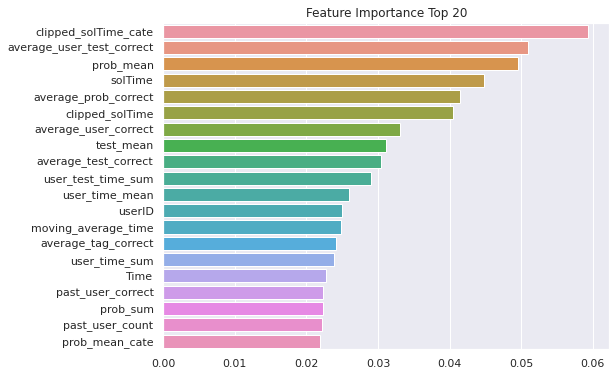

In [104]:
forest = RandomForestClassifier(n_estimators=5, n_jobs=-1, random_state=42) # n_estimators: 사용할 tree수
forest.fit(X_train, y_train)

# 배열형태로 반환
ft_importance_values = forest.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
ft_series = pd.Series(ft_importance_values, index = X_train.columns)
ft_top20 = ft_series.sort_values(ascending=False)[:20]

# 시각화
plt.figure(figsize=(8,6))
plt.title('Feature Importance Top 20')
sns.barplot(x=ft_top20, y=ft_top20.index)
plt.show()

In [105]:
lgb_data = lgb.Dataset(X_train, y_train)
model = lgb.train(
                    {'objective': 'binary'}, 
                    lgb_data,
                    valid_sets=lgb_data,
                    verbose_eval=100,
                    num_boost_round=500,
                    early_stopping_rounds=100
                )

[LightGBM] [Info] Number of positive: 1483205, number of negative: 783381
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.232131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7748
[LightGBM] [Info] Number of data points in the train set: 2266586, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654378 -> initscore=0.638341
[LightGBM] [Info] Start training from score 0.638341
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.449373
[200]	training's binary_logloss: 0.445486
[300]	training's binary_logloss: 0.443275
[400]	training's binary_logloss: 0.441352
[500]	training's binary_logloss: 0.439605
Did not meet early stopping. Best iteration is:
[500]	training's binary_logloss: 0.439605


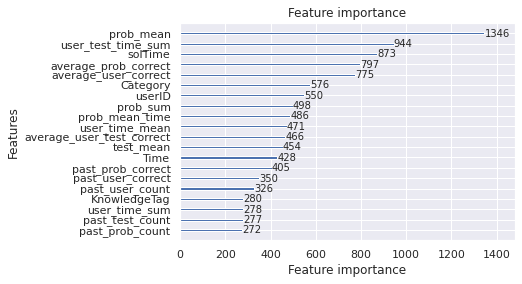

In [106]:
_ = lgb.plot_importance(model, max_num_features=20)